In [1]:


import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Preprocess the dataset
def preprocess_data(file_path):
    coffee_data = pd.read_csv(file_path)

    coffee_data['review_date'] = pd.to_datetime(coffee_data['review_date'], format='%B %Y', errors='coerce')
    coffee_data = coffee_data.dropna(subset=['review_date'])  # Remove rows with NaN dates

    coffee_data['review_year'] = coffee_data['review_date'].dt.year

    coffee_data['original_100g_USD'] = coffee_data['100g_USD']
    coffee_data['original_rating'] = coffee_data['rating']
    coffee_data['original_review_year'] = coffee_data['review_year']

    scaler = MinMaxScaler()
    coffee_data[['100g_USD', 'rating', 'review_year']] = scaler.fit_transform(
        coffee_data[['original_100g_USD', 'original_rating', 'original_review_year']]
    )

    return coffee_data, scaler


In [2]:
from scipy.spatial import KDTree

def build_kd_tree(filtered_data, selected_attributes):
    kd_tree_data = filtered_data[selected_attributes].to_numpy()
    kd_tree = KDTree(kd_tree_data)
    return kd_tree

def query_kd_tree(kd_tree, filtered_data, query_point, n_results, selected_attributes):
    distances, indices = kd_tree.query([query_point], k=n_results)
    return filtered_data.iloc[indices[0]]


In [3]:
from pyqtree import Index

def build_quad_tree(filtered_data):
    quad_tree = Index(bbox=[0, 0, 1, 1])
    for idx, row in filtered_data.iterrows():
        x, y = row['100g_USD'], row['rating']
        quad_tree.insert(idx, bbox=[x, y, x, y])
    return quad_tree

def query_quad_tree(quad_tree, filtered_data, query_point, query_radius):
    x, y = query_point
    query_bbox = [x - query_radius, y - query_radius, x + query_radius, y + query_radius]
    indices = quad_tree.intersect(query_bbox)
    return filtered_data.iloc[indices]


In [4]:
import bisect

class RangeTree:
    def __init__(self, points):
        self.points = sorted((value, idx) for idx, value in enumerate(points))

    def range_query(self, low, high):
        sorted_values = [value for value, idx in self.points]

        left = bisect.bisect_left(sorted_values, low)
        right = bisect.bisect_right(sorted_values, high)

        return [idx for value, idx in self.points[left:right]]


In [5]:
from rtree import index

def build_rtree(filtered_data):
    rtree_idx = index.Index()
    for i, row in filtered_data.iterrows():
        x, y = row['100g_USD'], row['rating']
        rtree_idx.insert(i, (x, y, x, y))
    return rtree_idx

def query_rtree(rtree_idx, filtered_data, query_point, query_radius):
    x, y = query_point
    results = list(rtree_idx.intersection((x - query_radius, y - query_radius, x + query_radius, y + query_radius)))
    return filtered_data.iloc[results]


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

def prepare_lsh(filtered_data, text_column='review'):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(filtered_data[text_column])
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine').fit(tfidf_matrix)
    return vectorizer, nbrs

def query_lsh(vectorizer, nbrs, query_text, filtered_data, n_results):
    query_vector = vectorizer.transform([query_text])
    distances, indices = nbrs.kneighbors(query_vector, n_neighbors=min(n_results, len(filtered_data)))
    return filtered_data.iloc[indices[0]]


In [7]:
def interactive_query_system(file_path, start_year, end_year, min_rating, min_price, max_price, country, n_results, query_text, indexing_method):
    coffee_data, scaler = preprocess_data(file_path)

    filtered_data = coffee_data[
        (coffee_data['original_review_year'] >= start_year) &
        (coffee_data['original_review_year'] <= end_year) &
        (coffee_data['original_rating'] >= min_rating) &
        (coffee_data['original_100g_USD'] >= min_price) &
        (coffee_data['original_100g_USD'] <= max_price) &
        (coffee_data['loc_country'] == country)
    ].reset_index(drop=True)

   # print(f" DEBUG: Total rows after filtering: {len(filtered_data)}")

    if filtered_data.empty:
        print("No results found.")
        return

    #  Normalize Query Point
    query_point = scaler.transform(pd.DataFrame(
        [[min_price + (max_price - min_price) / 2, min_rating, (start_year + end_year) / 2]],
        columns=['original_100g_USD', 'original_rating',  'original_review_year']
    ))[0]

    start_time = time.time()

    if indexing_method == "kd_tree":
        index_structure = build_kd_tree(filtered_data, ['100g_USD', 'rating', 'review_year'])
        results = query_kd_tree(index_structure, filtered_data, query_point, n_results, ['100g_USD', 'rating', 'review_year'])

    elif indexing_method == "quad_tree":
        index_structure = build_quad_tree(filtered_data)
        results = query_quad_tree(index_structure, filtered_data, query_point[:2], query_radius=0.1) 
        
    elif indexing_method == "range_tree":
        range_tree = RangeTree(filtered_data['rating'].tolist())
        range_indices = range_tree.range_query(min_rating, 100)
       
        results = filtered_data.iloc[range_indices]

    elif indexing_method == "r_tree":
        index_structure = build_rtree(filtered_data)
        results = query_rtree(index_structure, filtered_data, query_point[:2], query_radius=0.1) 
    else:
        print("Invalid indexing method.")
        return
    
    if results.empty:
        print("No indexing results found.")
        return
    
    indexing_time = time.time() - start_time

     # Display All Filtered Data First
    print("\n🔎 Filtered Data (Before Similarity Matching):")
    print(filtered_data[['name', 'original_100g_USD', 'original_rating', 'original_review_year', 'loc_country', 'review']].to_string(index=False))

    # Run LSH only if results are found
    if not results.empty:
        vectorizer, nbrs = prepare_lsh(results)
        lsh_start_time = time.time()
        lsh_results = query_lsh(vectorizer, nbrs, query_text, filtered_data, n_results)
        lsh_time = time.time() - lsh_start_time

        print("\nLSH Results:")
        print(lsh_results[['name', 'original_100g_USD', 'original_rating', 'original_review_year', 'loc_country', 'review']].to_string(index=False))
    else:
       lsh_time = 0
       print("No LSH results found.")

    total_time = indexing_time + lsh_time
    return total_time



 Running for kd_tree + LSH...


🔎 Filtered Data (Before Similarity Matching):
                                                      name  original_100g_USD  original_rating  original_review_year   loc_country                                                                                                                                                                                                                                                                                                                                                                                                                            review
                                  Ethiopia Shakiso Mormora               4.70               92                  2017 United States                                                                                                                 Crisply sweet, cocoa-toned. Lemon blossom, roasted cacao nib, date, rice candy, white peppercorn in aroma and cup. Savory-tart st

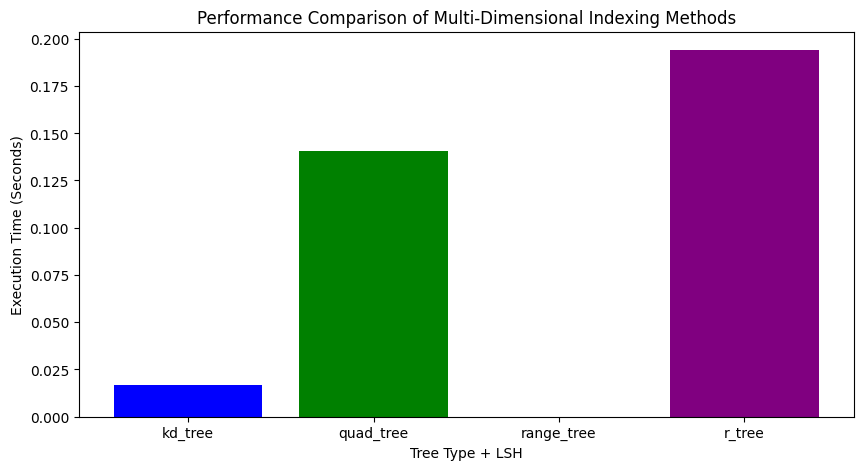

In [8]:

#Run Queries & Collect Time Data
file_path = "simplified_coffee.csv"
times = {}

for tree_type in ["kd_tree", "quad_tree", "range_tree", "r_tree"]:
    print(f"\n Running for {tree_type} + LSH...\n")
    execution_time = interactive_query_system(file_path, 2017, 2022, 90, 4, 15, "United States", 5, "rich", tree_type)
    times[tree_type] = execution_time if execution_time is not None else 0  


# Visualization
import numpy as np
times = {k: (v if v is not None else np.nan) for k, v in times.items()}  
plt.figure(figsize=(10, 5))
plt.bar(times.keys(), times.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Tree Type + LSH")
plt.ylabel("Execution Time (Seconds)")
plt.title("Performance Comparison of Multi-Dimensional Indexing Methods")
plt.show()

